# Metamers

Metamers are an old concept in the study of perception, dating back to the color-matching experiments in the 18th century that first provided support for the existence of three cone types (though it would be another two hundred years before anatomical evidence was found). These color-matching evidences demonstrated that, by combining three colored lights in different proportions, you could generate a color that humans perceived as identical to any other color, even though their physical spectra were different. Perceptual metamers, then, refer to two images that are physically different but perceived as identical.

For the purposes of `plenoptic`, wherever we say "metamers", we mean "model metamers": images that are physically different but have identical representation for a given model, i.e., that the model "perceives" as identical. Like all synthesis methods, it is model-specific, and one potential experiment is to determine if model metamers can serve as human percpetual metamers, which provides support for the model as an accurate representation of the human visual system.

In the Lab for Computational Vision, this goes back to [Portilla and Simoncelli, 2001](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf), where the authors created a parametric model of textures and synthesized novel images as a way of demonstrating the cases where the model succeeded and failed. In that paper, the model did purport to have anything to do with human vision, and they did not refer to their images as "metamers", that term did not appear until [Freeman and Simoncelli, 2011](https://www.cns.nyu.edu/pub/eero/freeman10-reprint.pdf), where the authors pool the Portilla and Simoncelli texture statistics in windows laid out in a log-polar fashion to generate putative human perceptual metamers.

This notebook demonstrates how to use the `Metamer` class to generate model metamers. Because `Metamer` is, in some senses, the most basic of the synthesis methods and much functionality is shared across synthesis methods, this also serves as a demonstration of much of the basic functionality of these classes.

In [2]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our model.

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/data.py:83: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


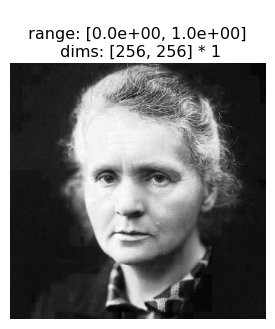

In [3]:
img = po.load_images(['../data/curie.pgm'])
po.imshow(img);

For the model, we'll use a model inspired by the Freeman and Simoncelli, 2011 paper: it pools energy at several orientations and spatial scales in Gaussian windows laid out in a log-polar fashion. (Note that in this notebook, I'll use a model, a class implementation, throughout, but that `Metamer` also works with metrics, function implementations, as well. See the initialization docstring for more details and the [MAD_Competition](MAD_Competition.ipynb) notebook for examples)

In [4]:
v1 = po.simul.PooledV1(.5, img.shape[2:])

AttributeError: module 'plenoptic.simulate' has no attribute 'PrimaryVisualCortex'

Like all of our models, when this is called on the image, it returns a tensor (in this case, 3d). This model also has an implemented `plot_representation` function, which takes that 3d tensor and reshapes it to show the different components at the different scales and bands. This representation is what the `Metamer` class will try to match.

tensor([[[2.5210e-05, 1.5659e-05, 5.5635e-06,  ..., 3.2889e-02,
          1.7403e-05, 0.0000e+00]]])


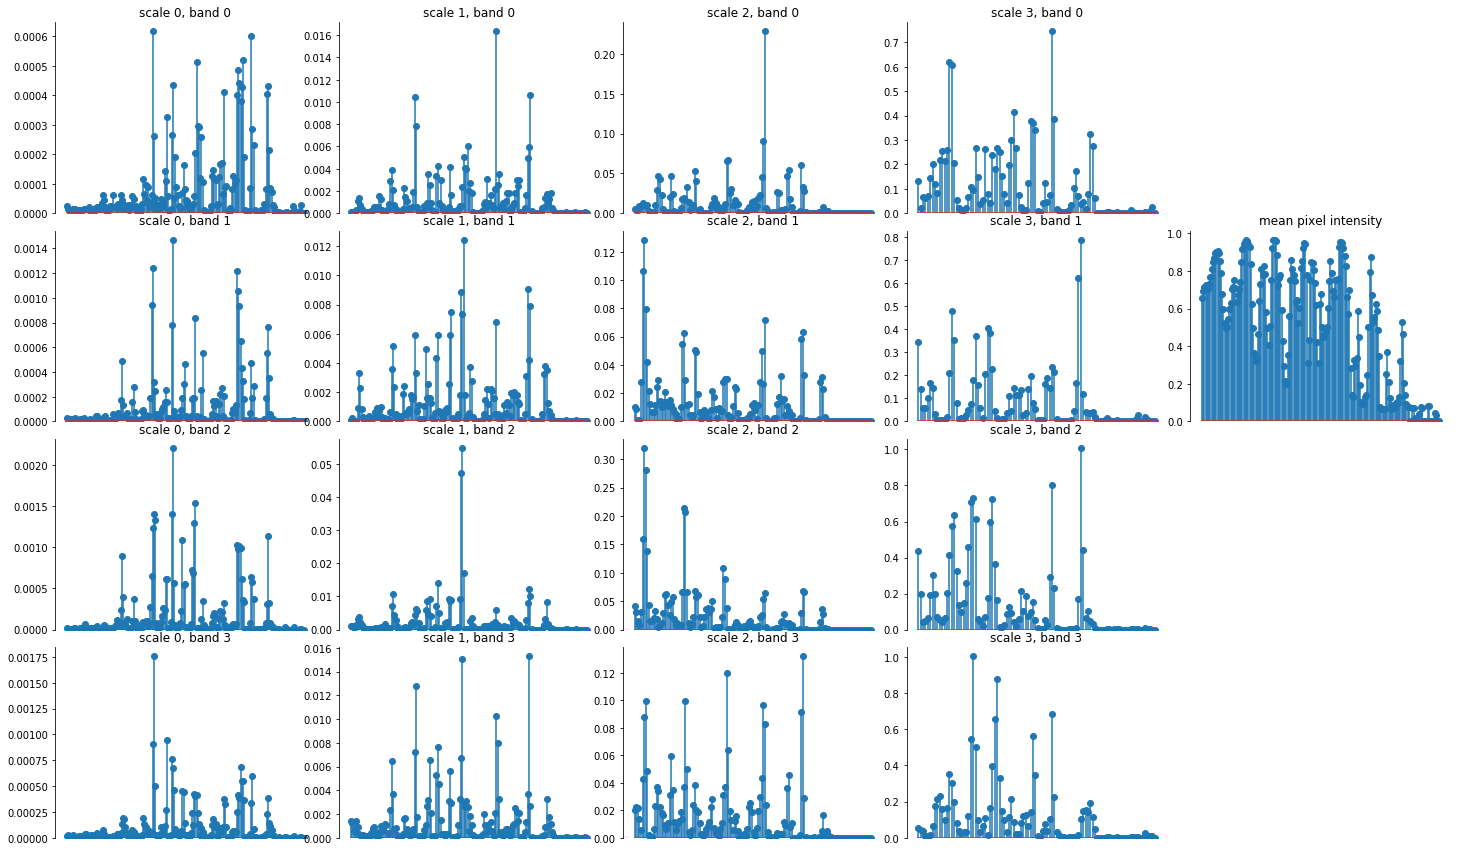

In [4]:
print(v1(img))
v1.plot_representation();

At the simplest, to use `Metamer`, simply initialize it with the target image and the model, then call `.synthesize()`. By setting `store_progress=True`, we update a variety of attributes (all of which start with `saved_`) on each iteration so we can later examine, for example, the synthesized image over time.

In [5]:
met = po.synth.Metamer(img, v1)
met.synthesize(store_progress=True)

100%|██████████| 100/100 [00:23<00:00,  3.36it/s, gradient_norm=1.1762e-01, learning_rate=0.01, loss=5.7739e+00]


(tensor([[[[0.4928, 0.7647, 0.0850,  ..., 0.3495, 0.1989, 0.3109],
           [0.0012, 0.7225, 0.2566,  ..., 0.6634, 0.3522, 0.8052],
           [0.3583, 0.3106, 0.6229,  ..., 0.1461, 0.3887, 0.9301],
           ...,
           [0.3095, 0.4690, 0.3260,  ..., 0.9916, 0.4158, 0.8542],
           [0.0946, 0.9094, 0.6189,  ..., 0.0605, 0.7176, 0.1476],
           [0.8890, 0.3844, 0.0960,  ..., 0.0181, 0.4339, 0.7129]]]]),
 tensor([[[1.0781e-02, 4.8444e-03, 3.1731e-03,  ..., 5.2674e-01,
           1.9484e-04, 0.0000e+00]]]))

We then call the `plot_synthesis_status` method to see how things are doing. The image on the left shows the metamer at this moment, while the center plot shows the loss over time, with the red dot pointing out the current loss, and the rightmost plot shows the representation error. Because `PooledV1` has a `plot_representation` method, this is more informative, but this plot can always be created. We here see the difference in representations split up into different spatial scales and orientation bands, and can see that the loss is concentrated in the highest / coarsest scale. If we return to the representation plot above, this is not surprising, because the representations at different scales have vastly different magnitudes. In practice, you'd probably want to normalize these elements of the representation (by setting `norm_dict`, see `SOME OTHER TUTORIAL` for details) or use a loss function that takes this into account. For the purposes of demonstrating how to use `Metamer` however, we won't do that.

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:799: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")
/home/billbrod/Documents/plenoptic/plenoptic/simulate/models/ventral_stream.py:1584: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


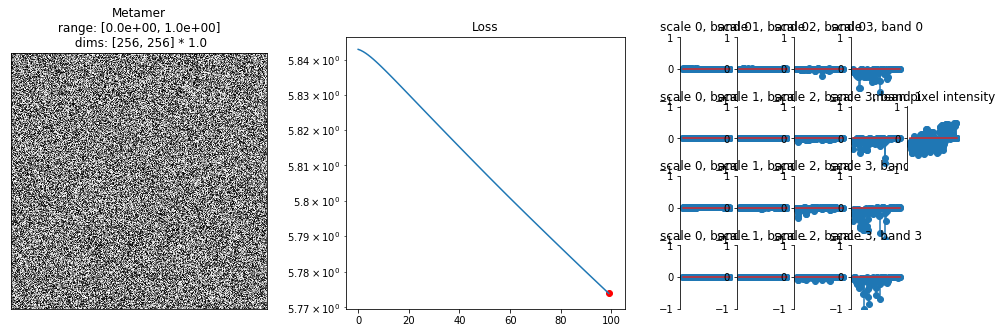

In [6]:
met.plot_synthesis_status();

`plot_synthesis_status()` is a helper function to show all of this at once, but the individual components can be created separately:

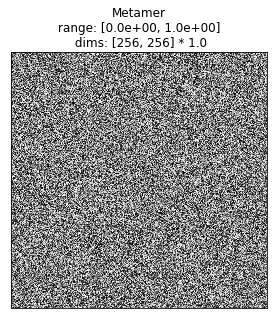

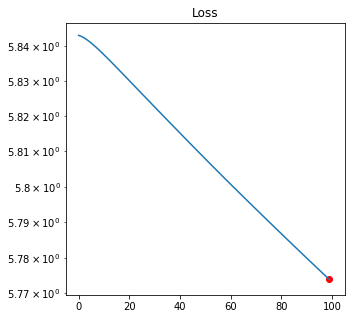

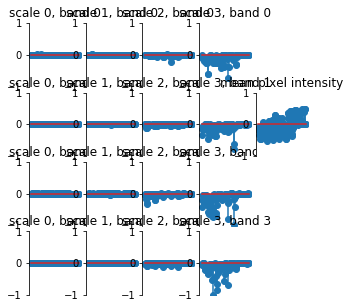

In [7]:
met.plot_synthesized_image()
met.plot_loss()
met.plot_representation_error();

The loss is decreasing, but clearly there's much more to go. So let's continue.

You can resume synthesis as long as you set ``store_progress!=False`` on the first run. You can then pick up where synthesis left by setting the initializing value (`initial_image`) to `None`. To most directly resume where you left off, it's recommended you set ``learning_rate=None``, in which case we use the most recent learning rate (since we use a learning rate scheduler, the learning rate decreases over time as the gradient shrinks), and `seed=None`, to avoid resetting it. ``store_progress`` has to have the same value between calls and we'll throw an Exception if that's not the case; you can set ``store_progress=None`` to re-use your ``store_progress`` argument. Coarse-to-fine optimization will also resume where you left off.

Everything that stores the progress of the optimization (``loss``, ``saved_representation``, ``saved_signal``) will persist between calls and so potentially get very large. 

In [8]:
met.synthesize(initial_image=None, seed=None, learning_rate=None, store_progress=True, max_iter=200)

100%|██████████| 200/200 [01:28<00:00,  4.25it/s, gradient_norm=1.0627e-01, learning_rate=0.01, loss=5.6557e+00]


(tensor([[[[0.4857, 0.7575, 0.0777,  ..., 0.3407, 0.1902, 0.3022],
           [0.0000, 0.7158, 0.2499,  ..., 0.6552, 0.3441, 0.7972],
           [0.3522, 0.3045, 0.6167,  ..., 0.1386, 0.3812, 0.9226],
           ...,
           [0.3051, 0.4648, 0.3219,  ..., 0.9875, 0.4115, 0.8498],
           [0.0901, 0.9051, 0.6146,  ..., 0.0563, 0.7131, 0.1430],
           [0.8843, 0.3799, 0.0916,  ..., 0.0138, 0.4294, 0.7082]]]]),
 tensor([[[1.0445e-02, 4.8721e-03, 3.1459e-03,  ..., 5.2226e-01,
           1.9468e-04, 0.0000e+00]]]))

Let's examine the status again. But instead of looking at the most recent status, let's look at 10 from the end:

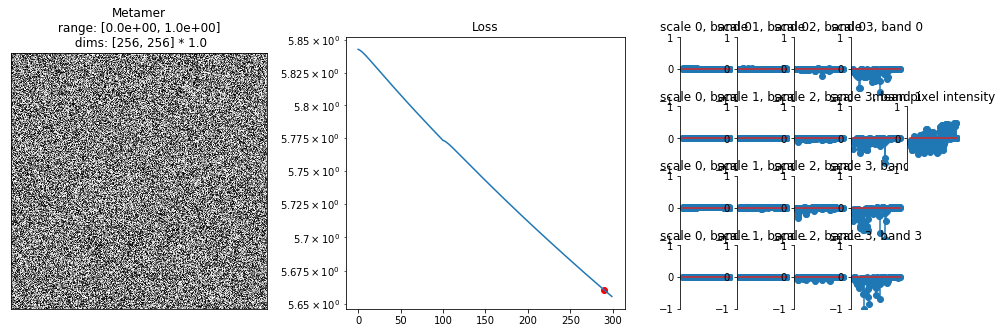

In [9]:
met.plot_synthesis_status(iteration=-10);

Since we have the ability to select which iteration to plot (as long as we've been storing the information), we can create an animation showing the synthesis over time. The `matplotlib.animation` object that gets returned can't be viewed directly, it either has to be converted to html for display in the notebook (using the `convert_anim_to_html` function we provide) or saved as some video format (e.g., `anim.save('test.mp4'`), which requires `ffmpeg` to be installed and on your path.

In [10]:
anim = met.animate()
po.convert_anim_to_html(anim)

Generally speaking, synthesis will run until you hit `max_iter` iterations. However, synthesis can also stop if it looks like the loss has stopped changing. This behavior is controlled with the `loss_thresh` and `loss_change_iter` arguments: if the loss has changed by less than `loss_thresh` over the past `loss_change_iter` iterations, we stop synthesis.

### Moving between devices

`Metamer` has a `.to()` method for moving the object between devices or dtypes. Call it as you would call any `tensor.to` and it will move over the necessary attributes.

### Saving and loading

Finally, you probably want to save the results of your synthesis. As mentioned above, you can save the synthesis animation, and all of the plots return regular `matplotlib` Figures and can be manipulated as expected. The synthesized image itself is a tensor and can be detached, converted to a numpy array, and saved (either as an image or array) as you'd expect. `po.to_numpy` is a convenience function we provide for stuff like this, which detaches the tensor, sends it to the CPU, and converts it to a numpy array with dtype float32. Note that it doesn't squeeze the tensor, so you may want to do that yourself.

In [11]:
met_image = po.to_numpy(met.synthesized_signal).squeeze()
imageio.imwrite('test.png', met_image)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


The automatic conversion to the output dtype is generally pretty good, but we also provide a helper function, `po.convert_float_to_int` to help with this:

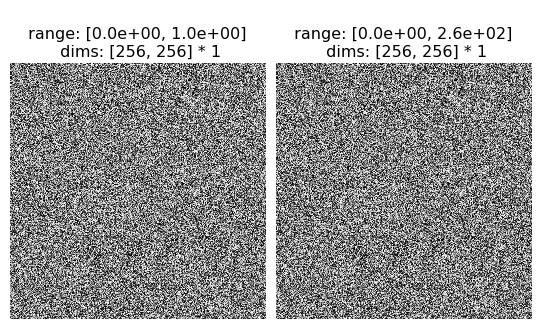

In [12]:
met_image_int = po.convert_float_to_int(met_image)
imageio.imwrite('test.png', met_image_int)
pt.imshow([met_image, met_image_int]);

You can also save the entire `Metamer` object. This can be fairly large (depending on how many iterations you ran it for and how frequently you stored progress), but stores all information:

In [13]:
met.save('test.pt')

You can then load it back in using the class method `Metamer.load`:

In [14]:
met_copy = po.synth.Metamer.load('test.pt')
(met_copy.saved_signal == met.saved_signal).all()

tensor(True)

If you're running synthesis for a long time, you probably want to save periodically in order to avoid losing progress if something goes wrong. To do that, use the `save_progress` argument. If `True`, we save every time we update the saved representation, i.e., every `store_progress` iterations. If an int, we save every `save_progress` iterations. Note that this can't be set if `store_progress=False`. (We try to save progress with `save_model_reduced=True`, see below for an explanation of that; if model doesn't have a `state_dict_reduced` attribute, we just save the full object).

Be warned that saving can actually take a fair amount of time, so you should only save infrequently, maybe every `max_iter//10` iterations or so.

The model itself can sometimes be large if it accumulates information when run, so we provide the option to store a reduced version of the model. This will not work with all models, relying on three specifications:

1. Any changes that happen to the model after initialization do not affect the model's behavior. For example, initializing the model and then changing an attribute so that the model calls a different non-linearity during the `forward` call would violate this.
2. The model has a `state_dict_reduced` attribute, a dictionary containing the arguments necessary to initialize the model
3. The model has a class method, probably called `from_state_dict_reduced`, which takes the `state_dict_reduced` dictionary referred to above and returns the initialized model

`PooledV1` satisfies these specs:

In [15]:
print(v1.state_dict_reduced)
v1_copy = po.simul.PooledV1.from_state_dict_reduced(v1.state_dict_reduced)

{'scaling': 0.5, 'img_res': torch.Size([256, 256]), 'min_eccentricity': 0.5, 'max_eccentricity': 15.0, 'transition_region_width': 0.5, 'cache_dir': None, 'window_type': 'cosine', 'std_dev': None, 'cone_power': 1.0, 'order': 3, 'model_name': 'V1', 'num_scales': 4, 'normalize_dict': {}, 'include_highpass': False}


/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1357: UserWarning: For scale 1, min_eccentricity set to 0.75 in order to avoid windows smaller than 1 pixel in area
  "windows smaller than 1 pixel in area" % (i, min_ecc))
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1357: UserWarning: For scale 2, min_eccentricity set to 1.50 in order to avoid windows smaller than 1 pixel in area
  "windows smaller than 1 pixel in area" % (i, min_ecc))
/home/billbrod/Documents/plenoptic/plenoptic/simulate/canonical_computations/pooling.py:1357: UserWarning: For scale 3, min_eccentricity set to 2.99 in order to avoid windows smaller than 1 pixel in area
  "windows smaller than 1 pixel in area" % (i, min_ecc))


And thus we can save a smaller version of the `Metamer` object:

In [16]:
met.save('test_reduced.pt', save_model_reduced=True)

If you have `du` installed on your system, the following block will show the reduced size.

In [17]:
!du -hs test_reduced.pt
!du -hs test.pt

158M	test_reduced.pt
179M	test.pt


When you load in the reduced version, you need to pass the new constructor:

In [18]:
met_copy = po.synth.Metamer.load('test_reduced.pt', model_constructor=po.simul.PooledV1.from_state_dict_reduced)
(met_copy.saved_signal == met.saved_signal).all()

tensor(True)

## Reproducibility

You can set the seed on the call to `synthesize()` for reproducibility (by default, this is set to `0`, to disable, pass `None`). This will set both the `pytorch` and `numpy` seeds, but note that we can't guarantee complete reproducibility: see [pytroch docs](https://pytorch.org/docs/stable/notes/randomness.html) for some caveats (we currently do not do the stuff described under CuDNN), as well as [this issue](https://github.com/LabForComputationalVision/plenoptic/issues/16) about resuming state after saving.

Also note that pytorch does not guarantee identical results between CPU and GPU, even with the same seed.

## More Advanced Options

One thing you may have noticed at the end of the [Basic usage section](#Basic-usage) is that it seems like the optimization had stabilized and the image wasn't changing as much. But, based on the loss and the representation error, we can see that there's still a long way to go before we find an actual metamer. Optimization in a high-dimensional space with non-linear models is inherently challenging and so we can't guarantee you'll find a model metamer, but we do provide some tools / extra functionality to help.

### Initialization

By default, the `initial_image` arg to `synthesize()` is `None`, in which case we initialize with uniformly-distributed random noise between 0 and 1. If you wish to use some other image for initialization, you can initialize it yourself (it must be the same shape as `base_signal`) and pass it as the `initial_image` arg.
 
### Optimization basics

You can set all the various optimization parameters you'd expect. `synthesize()` has `learning_rate` and `optimizer` args, so you can set the learning rate and choose from a small number of optimizers (for now, just Adam, SGD, and LBFGS). These algorithms have additional arguments (which you can find by looking into their pytorch documentation, e.g., by looking at the docstring of `torch.optim.Adam`), and these can be set by passing additional keyword arguments to `synthesize()`.

By default, we use a learning rate scheduler, which decreases the learning rate by half on plateaus. In order to disable this, set `scheduler=False`.

### Coarse-to-fine optimization

Some models, such as the `PooledV1` model used above or the Portilla-Simoncelli texture statistics, have a multiscale representation of the image, which can complicate the optimization. It's generally recommended that you normalize the representation (or use a specific loss function) so that the different scales all contribute equally to the representation, but that's out of the scope of this notebook.

We provide the option to use coarse-to-fine optimization, such that you optimize the different scales separately (starting with the coarsest and then moving progressively finer) and then, at the end, optimizing all of them simultaneously. This was first used in Portilla and Simoncelli, 2000, and can help avoid local optima in image space. Unlike everything else described in this notebook, it will not work for all models. There are two specifications the model must meet:

1. It must have a `scales` attribute that gives the scales in the order they should be optimized.
2. Its `forward()` method must accept a `scales` keyword argument, which accpets a list and causes the model to return only the scale(s) included. See `PooledV1.forward()` for an example.

There are two choices for how to handle coarse-to-fine optimization: `'together'` or `'separate'`. In `'together'` (recommended), we start with the coarsest scale and then gradually add each finer scale (thi sis like blurring the objective function and then gradually adding details). In `'separate'`, we compute the gradient with respect to each scale separately (ignoring the others), then with respect to all of them at the end.

In [19]:
print(v1.scales)
v1.forward(img, scales=[0])[..., :10]

['mean_luminance', 3, 2, 1, 0]


tensor([[[2.5210e-05, 1.5659e-05, 5.5635e-06, 2.2738e-06, 1.0266e-05,
          1.5592e-05, 1.5935e-05, 1.5317e-05, 4.9879e-06, 9.3902e-06]]])

If this is true, then we can call `synthesize()` with `coarse_to_fine=True` and it will work through the scales one at a time (and will resume correctly if you resume synthesis). Note that this will take a while, as it has to go through each scale. Also note that the progress bar now specifies which scale we're on.

In [20]:
met = po.synth.Metamer(img, v1)
met.synthesize(store_progress=True, coarse_to_fine=True, max_iter=100)

100%|██████████| 100/100 [00:19<00:00,  5.56it/s, current_scale=mean_luminance, current_scale_loss=3.95, gradient_norm=1.6100e-01, learning_rate=0.01, loss=5.7511e+00]


(tensor([[[[0.4913, 0.7632, 0.0833,  ..., 0.3476, 0.1970, 0.3090],
           [0.0000, 0.7210, 0.2551,  ..., 0.6616, 0.3505, 0.8035],
           [0.3570, 0.3093, 0.6215,  ..., 0.1444, 0.3870, 0.9285],
           ...,
           [0.3085, 0.4681, 0.3251,  ..., 0.9908, 0.4149, 0.8533],
           [0.0937, 0.9085, 0.6180,  ..., 0.0596, 0.7166, 0.1466],
           [0.8880, 0.3835, 0.0950,  ..., 0.0172, 0.4329, 0.7119]]]]),
 tensor([[[1.0728e-02, 4.8564e-03, 3.1719e-03,  ..., 5.2576e-01,
           1.9478e-04, 0.0000e+00]]]))

In order to control when synthesis considers a scale to be "done" and move on to the next one, you can set the `loss_change_iter` and `loss_change_thresh` arguments: if the scale-specific loss (`current_scale_loss` in the progress bar above) has changed by less than `loss_change_iter` over the past `loss_change_thresh` iterations, we consider that scale to have reached a local optimum and move on to the next.

In [21]:
met = po.synth.Metamer(img, v1)
met.synthesize(store_progress=True, coarse_to_fine=True, max_iter=200, loss_change_thresh=.1, loss_change_iter=10)

100%|██████████| 200/200 [00:52<00:00,  3.79it/s, current_scale=all, current_scale_loss=5.73, gradient_norm=1.1329e-01, learning_rate=0.01, loss=5.7303e+00]          


(tensor([[[[0.4903, 0.7623, 0.0825,  ..., 0.3465, 0.1959, 0.3079],
           [0.0000, 0.7202, 0.2544,  ..., 0.6606, 0.3494, 0.8025],
           [0.3562, 0.3086, 0.6208,  ..., 0.1435, 0.3861, 0.9276],
           ...,
           [0.3080, 0.4676, 0.3246,  ..., 0.9902, 0.4143, 0.8527],
           [0.0931, 0.9079, 0.6174,  ..., 0.0591, 0.7160, 0.1460],
           [0.8874, 0.3829, 0.0945,  ..., 0.0167, 0.4324, 0.7113]]]]),
 tensor([[[1.0667e-02, 4.8470e-03, 3.1638e-03,  ..., 5.2520e-01,
           1.9476e-04, 0.0000e+00]]]))

And we can see these shfits happening in the animation of synthesis:

In [22]:
po.convert_anim_to_html(met.animate())

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:796: UserWarning: ax is not None, so we're ignoring figsize...
  if ax is None:
/home/billbrod/Documents/plenoptic/plenoptic/simulate/models/ventral_stream.py:1584: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


There are attributes of `Metamer` that are only used when `coarse_to_fine` is not `False`:
- `scales_loss`: this list contains the scale-specific loss at each iteration (that is, the loss computed on just the scale(s) we're optimizing on that iteration; which we use to determine when to switch scales).
- `scales`: this is a list of the scales in optimization order (i.e., from coarse to fine). The last entry will be `'all'` (since after we've optimized each individual scale, we move on to optimizing all at once). This attribute will be modified by the synthesize() method and is used to track which scale we're currently optimizing (the first one). When we've gone through all the scales present, this will just contain a single value: 'all'.
- `scales_timing`: this is a dictionary whose keys are the values of scales. The values are lists, with 0 through 2 entries: the first entry is the iteration where we started optimizing this scale, the second is when we stopped (thus if it's an empty list, we haven't started optimzing it yet).
- `scales_finished`: this is a list of the scales that we've finished optimizing (in the order we've finished). The union of this and `scales` will be the same as `metamer.model.scales`.

A small wrinkle: if `coarse_to_fine=='together'`, then none of these will ever contain the final, finest scale, since that is equivalent to `'all'`.

### Clip grad norm

With some models (I've seen it with models with a concave non-linearity), the gradient may get too large and the optimization runs into issues with numerical overflow. In order to avoid that, you can clip the gradient norm to a certain maximum by setting the `clip_grad_norm` argument to True or a float (if you set this to False, we don't clip the gradient norm). If True, then we use 1, which seems reasonable. Otherwise, we use the value set here. This may help, but even better is to have a linaer or convex model.

### Randomizers

We provide two ways to add a bit more randomization to the optimization. In addition to potentially avoiding local optima, they may increase the diversity of metamers that you find:

1. Only calculate the gradient with respect to some random subset of the model's representation. By setting ``fraction_removed`` to some number between 0 and 1, the gradient and loss are computed using a random subset of the representation on each iteration (this random subset is drawn independently on each trial).Therefore, if you wish to disable this (to use all of the representation), this should be set to 0. ADD CONNECTION TO SGD

2. Only calculate the gradient with respect to the parts of the representation that have the highest error. If we think the loss has stopped changing (by seeing that the loss ``loss_change_iter`` iterations ago is within ``loss_change_thresh`` of the most recent loss), then only compute the loss and gradient using the top ``loss_change_fraction`` of the representation. This can be combined wth ``fraction_removed`` so as to randomly subsample from this selection. To disable this (and use all the representation), this should be set to 1.

These are all disabled by default.

These will not work if you're using a metric instead of a model (and will raise an Exception), because these randomize the model's represntation, thereby destroying any spatial structure, and metrics rely on that structure to properly compute their value.

### Clampers

Finally, we provide "clampers", which globally set some statistics of the image. These may be properties of the image that your model constrains anyway or not; the clampers can make optimization easier by moving you into the correct neighborhood of image space.

By default, we use `RangeClamper((0, 1))`, which clamps the image values to lie between 0 and 1 (setting all values below 0 to 0 and all above 1 to 1). Optimization (and most models) can operate on arbitrary values, but in order to actually display an image, there's a minimum and maximum possible value (0 and 255 for 8-bit images, 0 and 65535 for 16-bit images) and by convention we typically work with values lying between 0 and 1 during optimization, and then map them to display values afterwards (optimizing over 8 or 16 bit integers makes things much more difficult). You can disable this by setting `clamper=None` but it's *really* not recommended.

The clampers are as follows:

 - `RangeClamper(range)`: clamp the range of the image to lie between `range[0]` and `range[1]`

 - `RangeRemapper(range)`: instead of clamping the range, remap it, so that

    ```
    im = im + im.min() + range[0]
    im = (im / im.max()) * range[1]
    ```


 - `TwoMomentsClamper(targ)`: clamp the range, mean, and variance of the image to match that of another image `targ` (typically, the target image)

 - `FourMomentsClamper(targ)`: clamp the range, mean, variance, skew, and kurtosis of the image to match that of another image `targ` (typically, the target image). NOTE that this currently has issues on GPUs for some reason.

By default, all of these clamper objects get called on the synthesized image on each iteration, after that image has been updated, by default. In order to disable that behavior, set `clamp_each_iter=False`, in which case the clamper will only be called at the end of synthesis.

## Additional Attributes
The `Metamer` object has many attributes and methods. All arguments passed to `synthesize()` are stored as attributes. Some other useful ones are as follows:

1. `loss`, `gradient`, `learning_rate`: we store the current loss, gradient norm, and learning rate after each iteration.
2. `scales_loss`, `scales_timing`: if we're doing coarse-to-fine optimization, these are dictionaries holding the scale-specific loss and the iterations we switched to and from each scale.
3. `matched_image`, `matched_representation`: the synthesized image and the model's representation of it.
4. `target_image`, `target_representation`: the target image (the one whose representation we're trying to match) and the model's representation of it.
5. `saved_image`, `saved_image_gradient`, `saved_representation`, `saved_representation_gradient`: if we're storing progress, these attributes store the synthesized image-in-progress, its gradient, the model's representation of it, and the gradient of the representation.